Что я понял изучая датасеты?

1. Категориальные переменные, конечно, можно преобразовать в порядковые, но делать этого зачастую не стоит, потому что мы не знаем есть ли линейная зависимость между категориями или нет. Если же порядковые переменные все-таки оставляются, то лучше также добавить квадраты/кубы для них
2. Можно проверить модели сразу, но не стоит проверять рабочесть моделей после каждого изменения в данных, потому что это тормозит процесс разработки и загромождает код
3. Сначала стоит проинспектировать nan и разобраться с ними, а потом преобразовывать категориальные данные в порядковые. Вообще преобразование в порядко
...

* Преобразовать категориальные в порядковые для анализа
* Провести анализ
* Собрать в один единый dataframe
* Вернуться к категориальным и отбросить ненужные стоблцы
* Заменить значения nan на 0, если nan означает отсутствие
* Провести анализ оставшихся nan
* Провести анализ outliers
* Провести анализ непрерывных данных на нормальность
* Протестировать различные модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
np.random.seed(100)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
all_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))

In [3]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Подготовка данных

## Удаление не нужных данных

In [3]:
stay_columns = pd.Series(['MSZoning', 'OverallQual', 'Neighborhood',
                        'YearBuilt', 'ExterQual', 'BsmtQual', 'TotalBsmtSF',
                        'CentralAir', 'GrLivArea',
                        'KitchenQual', 'GarageFinish',
                        'GarageArea'])

In [4]:
all_data = all_data.loc[:, stay_columns].copy()

## Конвертируем OverallQual в категориальные данные

In [5]:
replace_dict = {i: str(i) for i in range(11)}
all_data.loc[:, 'OverallQual'] = all_data.loc[:, 'OverallQual'].replace(replace_dict)

## Работа с  nan

### Заменим данные где nan означает отсутствие

In [6]:
(all_data.isna().sum(axis=0) / all_data.shape[0]).sort_values(ascending=False)

GarageFinish    0.054471
BsmtQual        0.027749
MSZoning        0.001370
TotalBsmtSF     0.000343
KitchenQual     0.000343
GarageArea      0.000343
OverallQual     0.000000
Neighborhood    0.000000
YearBuilt       0.000000
ExterQual       0.000000
CentralAir      0.000000
GrLivArea       0.000000
dtype: float64

In [7]:
replace_dict = {np.nan: 'no'}

Для подвала

In [8]:
mask = (all_data['TotalBsmtSF'] == 0)
all_data.loc[mask, ['TotalBsmtSF', 'BsmtQual']]  =  all_data.loc[mask, ['TotalBsmtSF', 'BsmtQual']].replace(replace_dict).copy()

Для гаража

In [9]:
mask = (all_data['GarageArea'] == 0)
all_data.loc[mask, ['GarageFinish']]  = all_data.loc[mask, ['GarageFinish']].replace(replace_dict).copy()

### Заменим отсутствующие данные

Для категориальных - мода
Для непрерывных - среднее

In [10]:
categorical_columns = ['MSZoning', 'GarageFinish', 'KitchenQual', 'BsmtQual', 'OverallQual']

categorical_df = all_data.loc[:, categorical_columns]
all_data.loc[:, categorical_columns] = categorical_df.fillna(categorical_df.mode().iloc[0])

In [11]:
continuous_columns = ['TotalBsmtSF', 'GarageArea', 'OverallQual']
cont_df = all_data.loc[:, continuous_columns]
all_data.loc[:, continuous_columns] = cont_df.fillna(cont_df.mean().iloc(0))

In [12]:
(all_data.isna().sum(axis=0) / all_data.shape[0]).sort_values(ascending=False)

MSZoning        0.0
OverallQual     0.0
Neighborhood    0.0
YearBuilt       0.0
ExterQual       0.0
BsmtQual        0.0
TotalBsmtSF     0.0
CentralAir      0.0
GrLivArea       0.0
KitchenQual     0.0
GarageFinish    0.0
GarageArea      0.0
dtype: float64

## Замена типа данных TotalBsmtSF  и GarageArea

По непонятной причине эти стобцы имеют тип object

In [13]:
all_data['TotalBsmtSF'] = pd.to_numeric(df_train['TotalBsmtSF'])
all_data['GarageArea'] = pd.to_numeric(df_train['GarageArea'])

## Найдем outliars в данных

In [14]:
df_train = all_data.iloc[: df_train.shape[0]].join(df_train['SalePrice'])
df_test = all_data.iloc[df_train.shape[0]:]

Рассмотрим все взаимоотношения

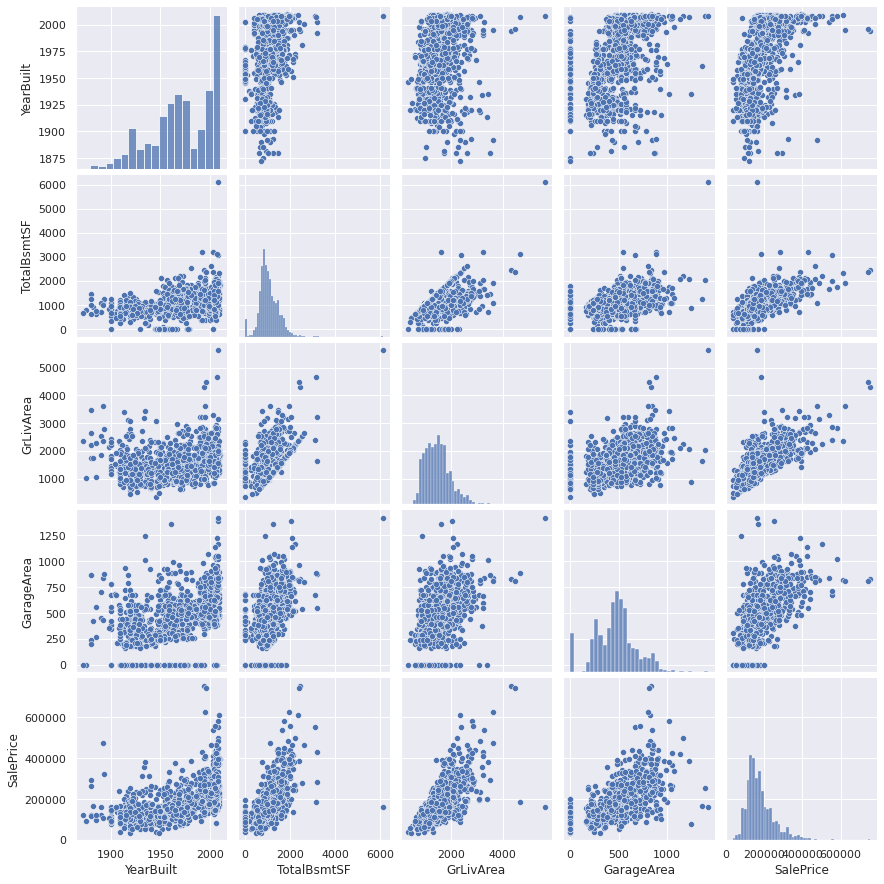

In [15]:
sns.pairplot(df_train)

Исходя из этих графиков можно сделать следующие выводы
1. Замета линейность между всеми фичасм и SalePrice за исключением YearBuilt
2. Не совсем нормальные распределения самих фич
3. Надо более детально рассмотреть GrLivArea и  GarageArea, так как можно заметить точки, отличающиеся от основной кучи

###  GrLivArea

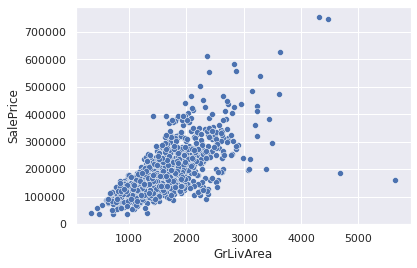

In [16]:
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice']);

In [17]:
mask  =(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 3e5)

df_train[mask]

,MSZoning,OverallQual,Neighborhood,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,GrLivArea,KitchenQual,GarageFinish,GarageArea,SalePrice
523,RL,10,Edwards,2007,Ex,Ex,3138,Y,4676,Ex,Fin,884,184750
1298,RL,10,Edwards,2008,Ex,Ex,6110,Y,5642,Ex,Fin,1418,160000


Эти данные очень подозрительны, удалим их

In [18]:
df_train.drop(df_train[mask].index, axis=0, inplace=True)

### TotalBsmtSF

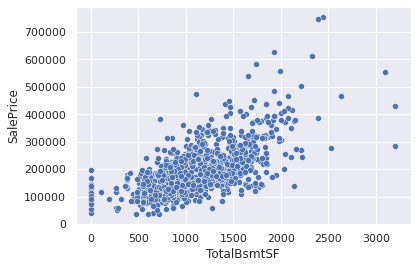

In [19]:
sns.scatterplot(x=df_train['TotalBsmtSF'], y=df_train['SalePrice']);

In [20]:
mask = df_train['TotalBsmtSF'] > 3000
df_train[mask]

,MSZoning,OverallQual,Neighborhood,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,GrLivArea,KitchenQual,GarageFinish,GarageArea,SalePrice
332,RL,8,NridgHt,2003,Gd,Gd,3206,Y,1629,Gd,RFn,880,284000
440,RL,10,NridgHt,2008,Ex,Ex,3094,Y,2402,Ex,Fin,672,555000
496,RL,8,NoRidge,1992,Gd,Gd,3200,Y,3228,Gd,RFn,546,430000


Данные значения мы не будем считать outliars, потому что у них просто площадь подвала значительно меньше  жилой площади, что в целом вписывается в модель

### Garage Area

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

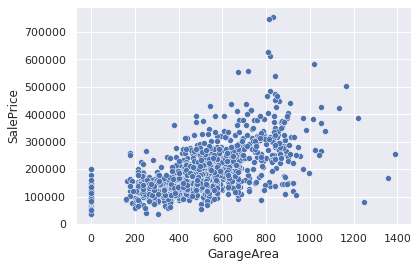

In [21]:
sns.scatterplot(data=df_train, x='GarageArea', y='SalePrice')

In [22]:
mask = (df_train['GarageArea'] > 1200) & (df_train['SalePrice'] < 3e5)
df_train[mask]

,MSZoning,OverallQual,Neighborhood,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,GrLivArea,KitchenQual,GarageFinish,GarageArea,SalePrice
581,RL,8,NridgHt,2008,Ex,Ex,2042,Y,2042,Ex,RFn,1390,253293
1061,C (all),3,IDOTRR,1935,Fa,TA,894,Y,894,TA,RFn,1248,81000
1190,RL,4,Mitchel,1961,TA,TA,1249,Y,1622,TA,Fin,1356,168000


Попробуем использовать наивного Гаусса для определения насколько эти данные далеки от распределения

Эти данные не слишком сильно выделяются, если посмотреть на другие характеристики, поэтому мы их оставим

##  Трансформирование фич

In [23]:
def plot_norm(series: pd.Series, ax=None):
    if ax is None:
        ax = plt.gca()
    mu, std = stats.norm.fit(series)
    xmin = series.min() - 1 *std
    xmax= series.max() + 1 * std
    x = np.linspace(xmin, xmax, 100)
    y = stats.norm.pdf(x, mu, std)
    ax.plot(x, y, 'k', linewidth=2)
    plt.xlim([xmin, xmax])

In [24]:
def plot_compare_with_normal(series: pd.Series):
    sns.displot(series, stat="density", kde=True)
    plot_norm(series)

### SalePrice

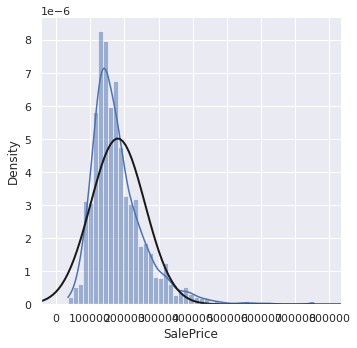

In [25]:
plot_compare_with_normal(df_train['SalePrice']);

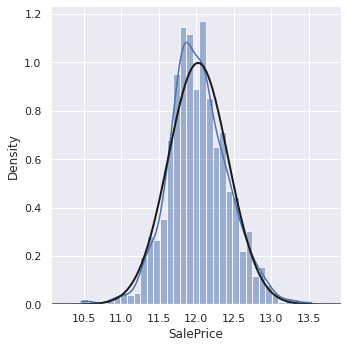

In [26]:
plot_compare_with_normal(np.log(df_train['SalePrice']));

Вывод: логорифмирование привело цену к нормально распределению

### YearBuilt

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

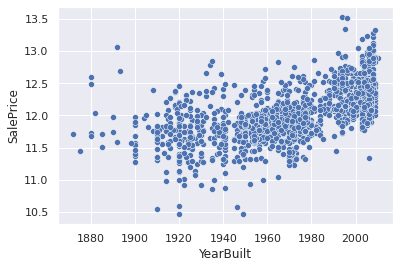

In [27]:
sns.scatterplot(x=df_train['YearBuilt'], y=np.log(df_train['SalePrice']))

Можем заметить, что логорифмирование SalePrice заставляет вести себя зависимость от года более линейной

### TotalBsmtSF

In [28]:
df_train['TotalBsmtSF'].dtype

dtype('int64')

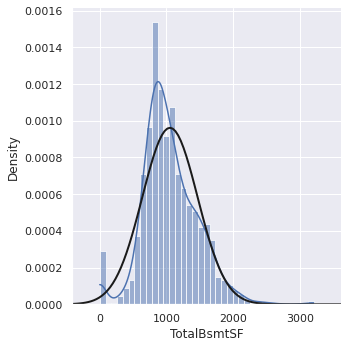

In [29]:
plot_compare_with_normal(df_train['TotalBsmtSF'])

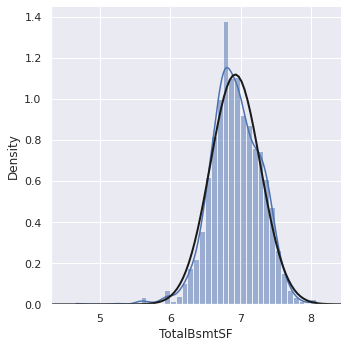

In [30]:
logged = np.log1p(df_train['TotalBsmtSF'])
plot_compare_with_normal(logged[logged > 0])

Оставим это преобразование, потому что оно оставляет нули нулями, а остальные переменные преобразует к нормальному распределению

### GrLivArea

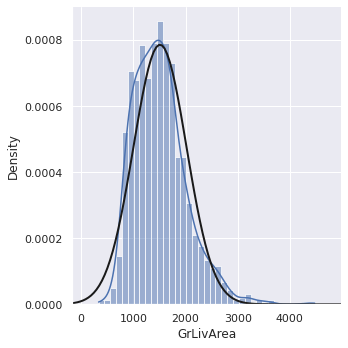

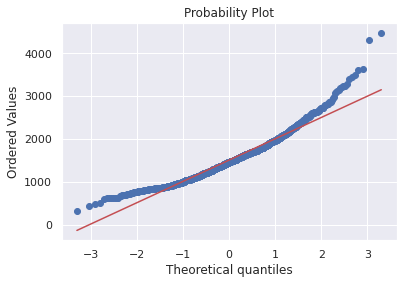

In [31]:
plot_compare_with_normal(df_train['GrLivArea'])
plt.figure()
stats.probplot(df_train['GrLivArea'], plot=plt);

In [32]:
df_train['GrLivArea'].skew()

1.0109917025385513

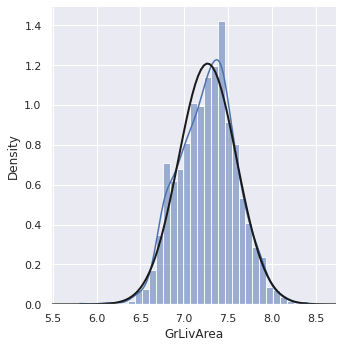

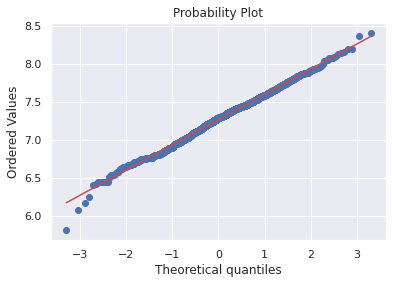

In [33]:
plot_compare_with_normal(np.log(df_train['GrLivArea']))
plt.figure()
stats.probplot(np.log(df_train['GrLivArea']), plot=plt);

Вывод: тоже логорифмируем

### GarageArea

In [34]:
df_train['GarageArea'].skew()

0.13174798037584048

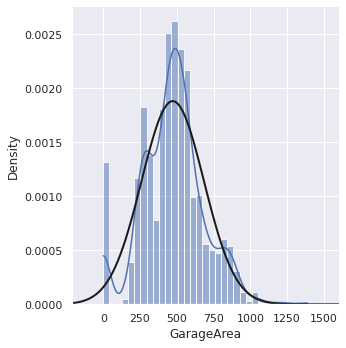

In [35]:
plot_compare_with_normal(df_train['GarageArea'])

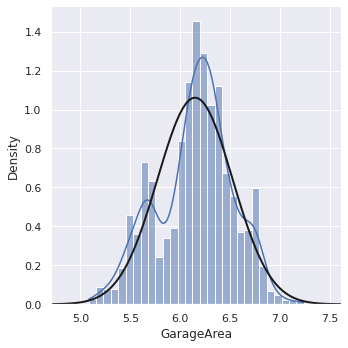

In [36]:
logged = np.log1p(df_train['GarageArea'])
mask = logged > 0
plot_compare_with_normal(logged[mask])

Логорифмирование ничего не дало => оставим как есть

### Применим трансформацию

In [37]:
for column in ['TotalBsmtSF', 'GrLivArea']:
    df_train.loc[:, column] = np.log1p(df_train[column])
    df_test.loc[:, column] = np.log1p(df_test[column])
df_train.loc[:, 'SalePrice'] = np.log1p(df_train['SalePrice'])

## Dummy

In [38]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Регрессия

In [39]:
def get_rmse(y_predicted, y_test):
    return round(np.sqrt(mean_squared_error(y_test, y_predicted)))

In [40]:
def plot_predictions(y_predicted, y_test, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(y_predicted, y_test, alpha=0.4)
    min_max = [0, 500000]
    ax.plot(min_max, min_max)
    ax.set_xlabel('y_predicted')
    ax.set_ylabel('y_test')


def plot_residuals(y_predicted, y_test, ax=None):
    if ax is None:
        ax = plt.gca()
    residuals = y_predicted - y_test
    ax.scatter(y_predicted, residuals, alpha=0.4)
    ax.plot([0, y_test.max()], [0, 0])
    ax.set_xlabel('SalePrice')
    ax.set_ylabel('Residual')

def plot_residuals_and_predictions(y_predicted, y_test, figsize=(14, 5)):
    _, axes = plt.subplots(1, 2, figsize=figsize)
    print('rmse:', get_rmse(y_predicted, y_test))
    plot_predictions(y_predicted, y_test, ax=axes[0])
    plot_residuals(y_predicted, y_test, ax=axes[1])

In [41]:
def get_grid_trainig_result(cv_results):
    result = pd.DataFrame(cv_results)
    result.sort_values(by='rank_test_score', inplace=True)
    result['mean_test_score'] = np.sqrt(-result['mean_test_score'])
    return result

In [42]:
def get_coefs_of_regression(regression, df):
    coeffs = dict(zip(df.columns.values, np.ravel(regression.coef_)))
    coeffs['intercept'] = regression.intercept_
    coeffs = pd.Series(coeffs).sort_values(ascending=False)
    return coeffs


In [43]:
X = df_train.drop(['SalePrice'], axis=1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### Ridge

In [44]:
def create_pipe(ridge_parameters):
    return Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', linear_model.RidgeCV(**ridge_parameters))])

ridge_parameters = {
    'alphas': [0.01,0.05, 0.1, 1, 4, 8, 16, 32, 64, 128],
    'cv': 10,
    'scoring': 'neg_root_mean_squared_error'
}
# обучаем модель, подбирая лучший параметр регуляризации
ridge_pipe = create_pipe(ridge_parameters)
ridge_pipe.fit(X_train, y_train)
# ищем вблики alpha, который оказался лучшем параметром
best_alpha = ridge_pipe['estimator'].alpha_
near_alphas = np.arange(0.6, 1.4, 0.05) * best_alpha
ridge_parameters['alphas'] = near_alphas
ridge_pipe = create_pipe(ridge_parameters)
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 RidgeCV(alphas=array([0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095, 0.1  ,
       0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135]),
                         cv=10, scoring='neg_root_mean_squared_error'))])

Посмотрим как себя ведет модель на тестовых данных

rmse: 27244


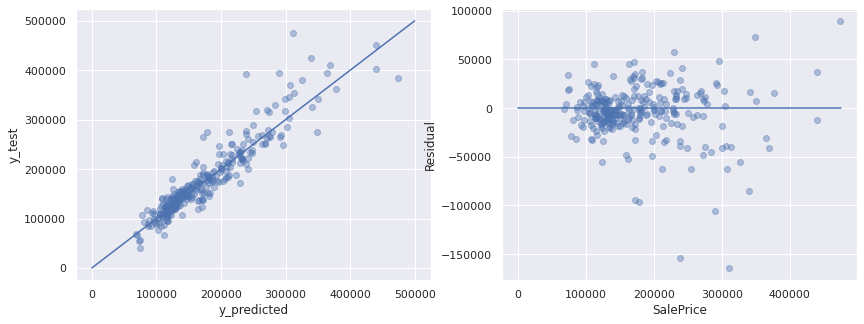

In [45]:
y_pred_test = ridge_pipe.predict(X_test)
plot_residuals_and_predictions(np.exp(y_pred_test), np.exp(y_test))

На тренировочных

rmse: 25537


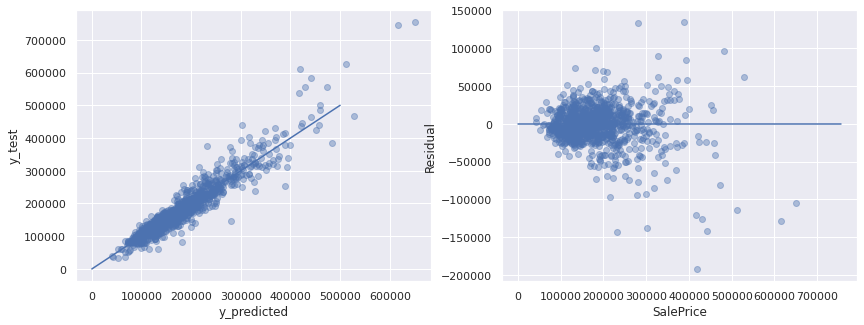

In [46]:
y_pred_train = ridge_pipe.predict(X_train)
plot_residuals_and_predictions(np.exp(y_pred_train), np.exp(y_train))

Посмотрим на фичи, которые модели считает наиболее значимыми

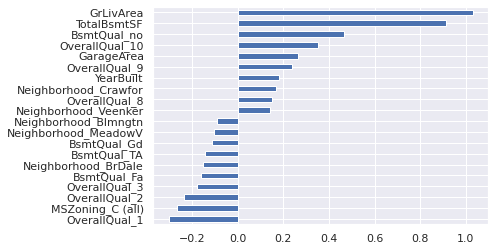

In [47]:
ridge_estimator = ridge_pipe['estimator']
coefs = pd.Series(ridge_estimator.coef_, index = X_train.columns)
coefs.sort_values(ascending=True, inplace=True)
pd.concat([coefs.head(10),coefs.tail(10)]).plot(kind='barh');

Вывод: рассматривать лассо не имеет слысла, так как регуляризация слишком мала

### RandomForest

In [53]:
from sklearn.metrics import fbeta_score, make_scorer

In [54]:
def func_for_make_scorer(y_pred, y):
    return get_rmse(np.exp(y_pred), np.exp(y))
rmse_scorer = make_scorer(func_for_make_scorer, greater_is_better=False)

In [55]:
random_forest_pipe = Pipeline([('estimator', RandomForestRegressor())])
random_forest_parameters = {'estimator__n_estimators' : [100],
                            'estimator__max_depth': [5, 10, 20, 40, 80]}
random_forest_grid = GridSearchCV(random_forest_pipe,
                                  random_forest_parameters,
                                  cv=10,
                                  scoring=rmse_scorer)

In [56]:
random_forest_grid.fit(X_train, y_train)
cv_result = get_grid_trainig_result(random_forest_grid.cv_results_)
cv_result['mean_test_score'] = cv_result.loc[:, 'split0_test_score': 'split9_test_score'].mean(axis=1)
print(cv_result[['param_estimator__n_estimators', 'param_estimator__max_depth', 'mean_test_score']])

  param_estimator__n_estimators param_estimator__max_depth  mean_test_score
2                           100                         20         -29839.2
3                           100                         40         -29947.5
4                           100                         80         -29990.4
1                           100                         10         -30110.5
0                           100                          5         -32830.9


Посмотрим как себя ведет модель на тестовых данных

rmse: 29817


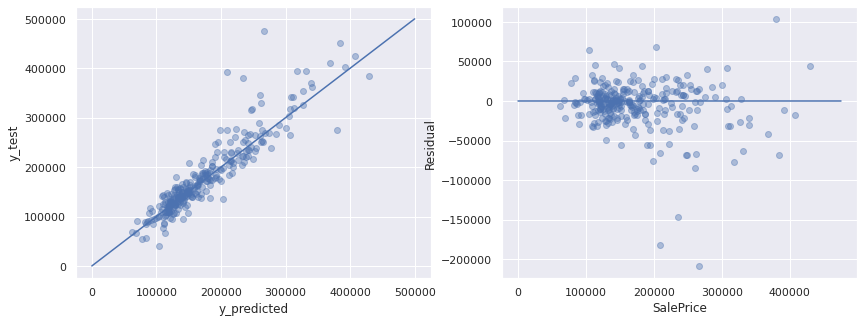

In [57]:
y_pred_test = random_forest_grid.predict(X_test)
plot_residuals_and_predictions(np.exp(y_pred_test), np.exp(y_test))

На тренировочных

rmse: 11561


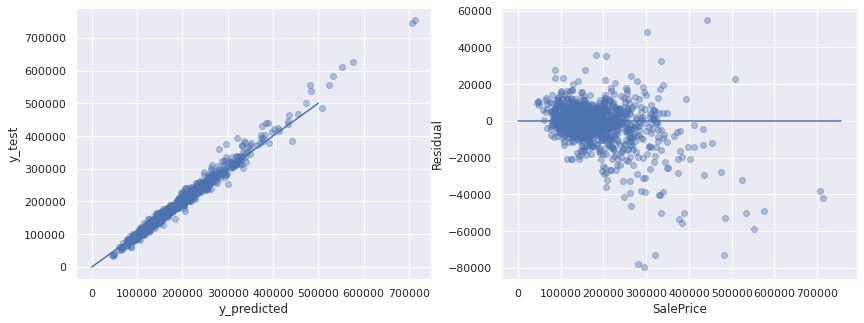

In [58]:
y_pred_train = random_forest_grid.predict(X_train)
plot_residuals_and_predictions(np.exp(y_pred_train), np.exp(y_train))

Вывод: на тренировочных данных ласа показывают себя неплохо, поэтому скорее всего наша модель переобучается, чтобы проверить это посмотрим на learning_curve

#### Learning curve for RandomForest

In [59]:
def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    return get_rmse(np.exp(y_pred), np.exp(y))

def plot_learning_curves(estimator, X, y, cv=5, n_cnt=5):
    ax = plt.gca()
    N, train_scores, test_scores = learning_curve(estimator, X, y,
                                                  cv=cv,
                                                  train_sizes=np.linspace(0.1, 1, n_cnt),
                                                  scoring=scoring)
    ax.plot(N, np.mean(train_scores, 1), color='blue', label='training score', marker='o')
    ax.plot(N, np.mean(test_scores, 1), color='red', label='validation score', marker='o')
    ax.legend()

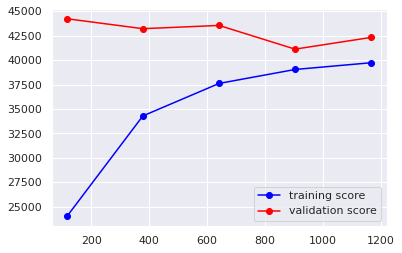

In [60]:
plot_learning_curves(RandomForestRegressor(max_depth=3), X, y, 5)

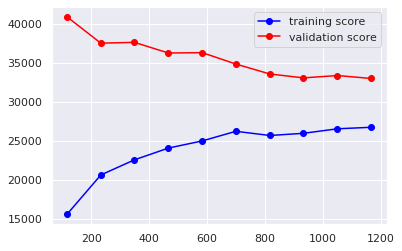

In [61]:
plot_learning_curves(RandomForestRegressor(max_depth=5), X, y, n_cnt=10)

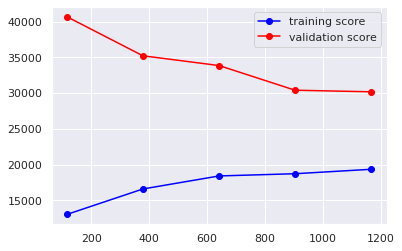

In [62]:
plot_learning_curves(RandomForestRegressor(max_depth=7), X, y, n_cnt=5)

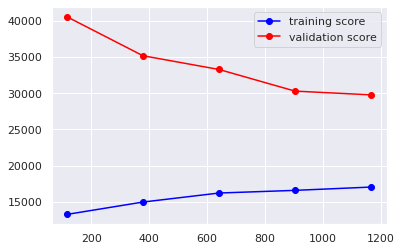

In [63]:
plot_learning_curves(RandomForestRegressor(max_depth=8), X, y, n_cnt=5)

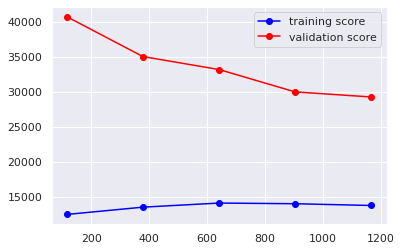

In [64]:
plot_learning_curves(RandomForestRegressor(max_depth=10, n_jobs=-1), X, y, n_cnt=5)

Видно, что модель переобучается и не подходит для наших данных

Вывод: переобученные модели предсказывают лучше чем недообученные, но разница небольшая, поэтому мы остановим на  max_depth=5

План подбора параметров для Случайных лесов:
* Мы провели эксперименты с max_depth и поняли, что, работая с этим параметром мы не достигаем улучшения модели
* Надо попробовать поработать с min_samples_leaf, но скорее всего это нам даст результат аналогичный с max_depth
* Интереснее является эксперементирование с max_feature, потому что тогда деревья не будут видеть всех фич
* Также надо попробовать тестировать модель при помощи oob_score


In [65]:
random_forest_oob = RandomForestRegressor(max_depth=10, oob_score=True)
random_forest_oob.fit(X, y)

RandomForestRegressor(max_depth=10, oob_score=True)

In [66]:
y_predicted = random_forest_oob.oob_prediction_
func_for_make_scorer(y_predicted, y)

29803

In [67]:
random_forest_oob.oob_prediction_

array([12.20777038, 11.99759331, 12.27346714, ..., 12.46309408,
       11.74664752, 11.73504419])

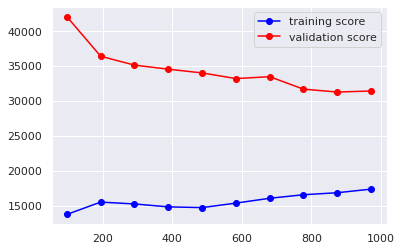

In [68]:
random_subspace = RandomForestRegressor(max_features=10, max_leaf_nodes=200)
plot_learning_curves(random_subspace, X, y, cv=3, n_cnt=10)

### AdaBoost

In [69]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [70]:
from sklearn.ensemble import AdaBoostRegressor
ada_clf = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=20), n_estimators=200, learning_rate=0.3)
cv = cross_validate(ada_clf, X, y, scoring=rmse_scorer)
pd.DataFrame(cv)

,fit_time,score_time,test_score
0,1.758754,0.048615,-31477
1,1.929504,0.031172,-31414
2,1.856643,0.080608,-30089
3,1.616640,0.035965,-25122
4,1.984266,0.029762,-30493


In [71]:
ada_clf = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=2), n_estimators=200, learning_rate=0.3)
cv = cross_validate(ada_clf, X, y, scoring=rmse_scorer)
pd.DataFrame(cv)

,fit_time,score_time,test_score
0,0.598771,0.021832,-39837
1,0.515722,0.020435,-37433
2,0.603309,0.052674,-46232
3,0.599653,0.021450,-36669
4,0.540812,0.019525,-43141


In [72]:
ada_clf = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=1000, learning_rate=0.3)
cv = cross_validate(ada_clf, X, y, scoring=rmse_scorer)
pd.DataFrame(cv)

,fit_time,score_time,test_score
0,3.481763,0.160307,-34902
1,3.410018,0.112195,-33001
2,3.235259,0.094150,-37114
3,3.035443,0.120136,-30452
4,3.664997,0.105154,-35406


### XGboost

In [73]:
from xgboost import XGBRegressor

In [95]:
xgb_regression = XGBRegressor(scroing=rmse_scorer, eta=0.2)
xgb_regression.fit(X_train, y_train, eval_set=[(X_test,  y_test)], early_stopping_rounds=10)

AssertionError: Must have at least 1 validation dataset for early stopping.

In [87]:
scoring(xgb_regression, X_test, y_test)

28166

In [96]:
from xgboost import cv, DMatrix

dtrain = DMatrix(X_train, y_train)
params = {'eta': 0.1, 'max_depth': 8}
xgb_cv = cv(dtrain=dtrain, params=params, early_stopping_rounds=10, metrics='rmse', as_pandas=True)

In [97]:
xgb_cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.383234,0.009254,10.383219,0.021552
1,9.347873,0.008337,9.347856,0.022478
2,8.416096,0.007514,8.416079,0.023311
3,7.577578,0.006773,7.577558,0.024063
4,6.823026,0.006108,6.823004,0.024740
5,6.144030,0.005474,6.144545,0.024354
6,5.532871,0.004865,5.533385,0.024258
7,4.982788,0.004355,4.983437,0.023311
8,4.487698,0.003858,4.487605,0.022602
9,4.042114,0.003432,4.042689,0.022995


Что я хочу от xgboost?

Хочу попробовать сделать early stoping без val_set, а только при помощи  кроссвалидации